# Data Preparation

In [66]:
import pandas as pd
import numpy as np
from IPython.display import display



loan_dev = pd.read_csv('data/loan_dev.csv', dtype={'date':object})
account = pd.read_csv('data/account.csv', dtype={'date':object})
card_dev = pd.read_csv('data/card_dev.csv', dtype={'issued':object})
client = pd.read_csv('data/client.csv')
disposition = pd.read_csv('data/disp.csv')
district = pd.read_csv('data/district.csv')
trans_dev = pd.read_csv('data/trans_dev.csv', dtype={'date':object})

pd.set_option('display.max_columns', None)


/var/folders/zc/rtmzz9rn11ggb_lnycv43dnr0000gn/T/ipykernel_46959/2552511720.py:13: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  trans_dev = pd.read_csv('data/trans_dev.csv', dtype={'date':object})


## Loan preparation

### Save

In [67]:
loan_dev.rename(columns={'date':'loan_date', 'amount': 'loan_amount', 'duration': 'loan_duration', 'payments': 'loan_payments' }, inplace=True)
loan_dev.to_csv('data_processed/loan_dev.csv', index=False)
loan_dev

,loan_id,account_id,loan_date,loan_amount,loan_duration,loan_payments,status
0,5314,1787,930705,96396,12,8033,-1
1,5316,1801,930711,165960,36,4610,1
2,6863,9188,930728,127080,60,2118,1
3,5325,1843,930803,105804,36,2939,1
4,7240,11013,930906,274740,60,4579,1
...,...,...,...,...,...,...,...
323,6818,9030,961212,155616,48,3242,1
324,5625,3189,961215,222180,60,3703,-1
325,6805,8972,961221,45024,48,938,1
326,7233,10963,961225,115812,36,3217,1


## Account preparation

In [68]:
account.drop(['date'], inplace=True, axis=1)

### Save

In [69]:
account.rename(columns={'frequency':'account_frequency', 'district_id': 'account_district_id'}, inplace=True)
account.to_csv('data_processed/account.csv', index=False)
account

,account_id,account_district_id,account_frequency
0,576,55,monthly issuance
1,3818,74,monthly issuance
2,704,55,monthly issuance
3,2378,16,monthly issuance
4,2632,24,monthly issuance
...,...,...,...
4495,124,55,monthly issuance
4496,3958,59,monthly issuance
4497,777,30,monthly issuance
4498,1573,63,monthly issuance


## Card preparation

There are only a few loans associated with a credit card

In [70]:
card_dev.drop(["issued"], inplace=True, axis=1)
card_dev = card_dev.fillna({'type': 'unkown'})

### Save

In [71]:
card_dev.rename(columns={'type':'card_type', 'disp_id': 'card_disp_id'}, inplace=True)
card_dev.to_csv('data_processed/card_dev.csv', index=False)

## Client preparation

### Extract gender and normalize dates
Since the birth date of each client is represented as YYMMDD when 'Male' or YY(MM+50)DD when 'Female' the gender was extracted as a new feature and the Female client's birth date modified to YYMMDD, the same as Male clients.
Female = False
Male = True

In [72]:
from datetime import datetime, timedelta

def extract_gender(date):
    month = int(str(date)[2:4])
    gender = ''
    if month > 12:
        month -= 50
        gender = 'Female'
    else: 
        gender = 'Male'
    new_date = str(date)[:2] + str(month).zfill(2) + str(date)[4:]
    return (new_date, gender)

In [73]:
genders = []
dates = []

for birth_number in client['birth_number']:
    (new_date, gender) = extract_gender(birth_number)
    dates.append(new_date)
    genders.append(gender)

client['birth_number'] = dates
client['gender'] = genders

### Save

In [74]:
client.rename(columns={'district_id': 'client_district_id'}, inplace=True)
client.to_csv('data_processed/client.csv', index=False)

## Disposition preparation

### Remove disponent clients and add to the account's owner entry
Without this chenage more than one client were associated to a single account_id. This was a problem when merging Dispositions Loans tables since this would lead to several entries with the same loan_id and target classes replicated.

In [75]:
disp_owners = disposition.loc[disposition['type'] == 'OWNER'].copy()
disp_disponent = disposition.loc[disposition['type'] == 'DISPONENT'].copy()

has_disponent = [id in disp_disponent['account_id'].values for id in disp_owners['account_id'].values]

disp_owners['has_disponent'] = has_disponent
disp_owners.drop('type', inplace=True, axis=1)
display(disp_owners)

,disp_id,client_id,account_id,has_disponent
0,1,1,1,False
1,2,2,2,True
3,4,4,3,True
5,6,6,4,False
6,7,7,5,False
...,...,...,...,...
5363,13623,13931,11333,False
5364,13647,13955,11349,True
5366,13660,13968,11359,False
5367,13663,13971,11362,False


### Save

In [76]:
disp_owners.to_csv('data_processed/disp.csv', index=False)

## District preparation

### Clean missing values

There was a row with missing values '?' in the district table for both "no. of commited crimes '95" and "unemploymant rate '95" columns. We needed to find a value for it, either replacing it with median or mean value of the column. To decide between median or mean, we need to analyse symmetry and the outliers of each column.

{'whiskers': [<matplotlib.lines.Line2D at 0x1357348b0>,
 'caps': [<matplotlib.lines.Line2D at 0x1357957c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x135734fa0>],
 'medians': [<matplotlib.lines.Line2D at 0x135795dc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x135795d00>],
 'means': []}

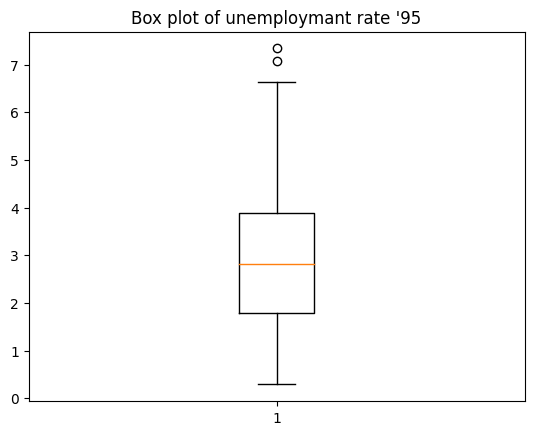

In [77]:
import matplotlib.pyplot as plt

district_clean = district.loc[(district["unemploymant rate '95"] != '?') & (district["no. of commited crimes '95"] != '?')]


plt.title("Box plot of unemploymant rate '95")
plt.boxplot(district_clean["unemploymant rate '95"].astype('float'))

{'whiskers': [<matplotlib.lines.Line2D at 0x13589d3d0>,
 'caps': [<matplotlib.lines.Line2D at 0x13589db20>,
 'boxes': [<matplotlib.lines.Line2D at 0x13589d130>],
 'medians': [<matplotlib.lines.Line2D at 0x135836070>],
 'fliers': [<matplotlib.lines.Line2D at 0x135836280>],
 'means': []}

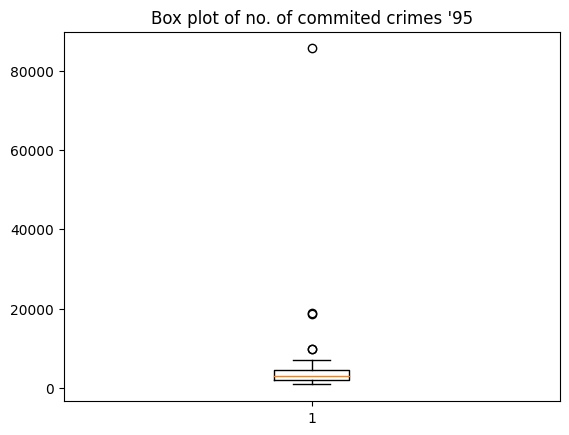

In [78]:
plt.title("Box plot of no. of commited crimes '95")
plt.boxplot(district_clean["no. of commited crimes '95"].astype('int'))

By analysing the box plots, we found out that the data values for "no. of commited crimes '95" and "unemploymant rate '95" are not symmetrical and there are outliers, therefore is would be best to use median instead of mean to replace the cells with '?'

In [79]:

median_unemploymant = district_clean["unemploymant rate '95"].astype(float).median()
median_commited_crimes = district_clean["no. of commited crimes '95"].astype(int).median()

# "no. of commited crimes '95" = '?' => median_commited_crimes
# "unemploymant rate '95" = '?' => median_unemploymant
district.loc[district["no. of commited crimes '95"] == '?', "no. of commited crimes '95"] = median_commited_crimes
district.loc[district["unemploymant rate '95"] == '?', "unemploymant rate '95"] = median_unemploymant

district.head()

,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


### Data Cleaning

In [80]:
# values of "no. of municipalities with inhabitants 2000-9999" and "no. of municipalities with inhabitants >10000" are really small compared to the other ones
district['no. of municipalities with inhabitants > 2000'] = district['no. of municipalities with inhabitants 2000-9999'] + district['no. of municipalities with inhabitants >10000']

district.drop(columns=['no. of municipalities with inhabitants 2000-9999',
'no. of municipalities with inhabitants >10000'], inplace=True)

cols = district.columns.tolist()
cols = cols[:6] + cols[-1:] + cols[6:-1]
district = district[cols]

district.head()

,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants > 2000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
0,1,Hl.m. Praha,Prague,1204953,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,8,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,5,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,8,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,5,6,51.4,9307,3.85,4.43,118,2616,3040


### Feature Engineering

In [81]:
# Create ratios and convert percentage to 0-1
district['ratio enterpreneurs'] = district['no. of enterpreneurs per 1000 inhabitants'] / 1000
district['ratio of urban inhabitants'] = district['ratio of urban inhabitants'] / 100

# Change rate to ratio growth
district['unemploymant rate growth'] = pd.to_numeric(district["unemploymant rate '96 "]) - pd.to_numeric(district["unemploymant rate '95"])
district['crime rate growth'] = (pd.to_numeric(district["no. of commited crimes '96 "]) - pd.to_numeric(district["no. of commited crimes '95"]))/pd.to_numeric(district["no. of inhabitants"])

district.drop(columns=['name', 'no. of enterpreneurs per 1000 inhabitants', 'no. of inhabitants',
"unemploymant rate '96 ", "no. of commited crimes '96 ",
"unemploymant rate '95", "no. of commited crimes '95"], inplace=True)

district.head()

,code,region,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants > 2000,no. of cities,ratio of urban inhabitants,average salary,ratio enterpreneurs,unemploymant rate growth,crime rate growth
0,1,Prague,0,0,1,1,1.000,12541,0.167,0.14,0.011146
1,2,central Bohemia,80,26,8,5,0.467,8507,0.132,0.18,0.005794
2,3,central Bohemia,55,26,5,5,0.417,8980,0.111,0.26,-0.000146
3,4,central Bohemia,63,29,8,6,0.674,9753,0.109,0.41,0.004323
4,5,central Bohemia,65,30,5,6,0.514,9307,0.118,0.58,0.004434


### Save

In [82]:
# TODO - clean district table
district.to_csv('data_processed/district.csv', index=False)

## Transaction preparation

### Replace missing values

In [83]:
# Replace type 'withdrawal in cash' with 'withdrawal'
trans_dev.replace({'type': 'withdrawal in cash'}, 'withdrawal', inplace=True)
# Replace k_symbol '' with nan
trans_dev.replace({'k_symbol': ' '}, np.nan, inplace=True)
# Replace operation 'credit card withdrawal' with 'withdrawal in cash'
trans_dev.replace({'operation': 'credit card withdrawal'}, 'withdrawal in cash', inplace=True)

In [84]:
# Replace NaN of operation with mode for each type
credit_operation_mode = trans_dev[trans_dev['type'] == 'credit']['operation'].mode()[0]
withdrawal_operation_mode = trans_dev[trans_dev['type'] == 'withdrawal']['operation'].mode()[0]
trans_dev['operation'] = trans_dev.apply(lambda x: credit_operation_mode if (x['type'] == 'credit' and pd.isnull(x['operation'])) else (withdrawal_operation_mode if (x['type'] == 'withdrawal' and pd.isnull(x['operation'])) else x['operation']), axis=1)

In [85]:
# Drop columns with more than 70% of missing values
trans_dev.dropna(thresh=len(trans_dev) * 0.3, axis=1, inplace=True)
trans_dev

,trans_id,account_id,date,type,operation,amount,balance,k_symbol
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,NaN
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,NaN
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,NaN
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,NaN
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,NaN
...,...,...,...,...,...,...,...,...
396680,515914,1763,961231,withdrawal,withdrawal in cash,14.6,67769.5,payment for statement
396681,516262,1765,961231,withdrawal,withdrawal in cash,14.6,19708.1,payment for statement
396682,520019,1775,961231,withdrawal,withdrawal in cash,14.6,15944.5,payment for statement
396683,517894,1769,961231,withdrawal,withdrawal in cash,14.6,34679.4,payment for statement


In [86]:
trans_dev.to_csv('data_processed/trans_dev_no_mv.csv', index=False)

### Feature Engineering - Monthly Income and last balance for each account_id

In [87]:
trans_dev['date'] = trans_dev['date'].apply(lambda x: '19'+x[:2]+'-'+x[2:4]+'-'+x[4:])
trans_dev['date'] = pd.to_datetime(trans_dev['date']).dt.date

In [88]:
aux = trans_dev.groupby(['account_id']).agg({'date': ['min', 'max']})
aux.columns = ['min_date', 'max_date']
aux = aux.reset_index(drop=False)
aux['date_diff'] = (aux['max_date']-aux['min_date'])/np.timedelta64(1, 'M')
aux['date_diff'] = aux['date_diff'].astype(int)
trans_dev = pd.merge(trans_dev, aux[['account_id', 'date_diff']], on='account_id', how='left')
display(trans_dev)

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,date_diff
0,1548749,5270,1993-01-13,credit,credit in cash,800.0,800.0,NaN,10
1,1548750,5270,1993-01-14,credit,collection from another bank,44749.0,45549.0,NaN,10
2,3393738,11265,1993-01-14,credit,credit in cash,1000.0,1000.0,NaN,7
3,3122924,10364,1993-01-17,credit,credit in cash,1100.0,1100.0,NaN,9
4,1121963,3834,1993-01-19,credit,credit in cash,700.0,700.0,NaN,19
...,...,...,...,...,...,...,...,...,...
396680,515914,1763,1996-12-31,withdrawal,withdrawal in cash,14.6,67769.5,payment for statement,9
396681,516262,1765,1996-12-31,withdrawal,withdrawal in cash,14.6,19708.1,payment for statement,5
396682,520019,1775,1996-12-31,withdrawal,withdrawal in cash,14.6,15944.5,payment for statement,46
396683,517894,1769,1996-12-31,withdrawal,withdrawal in cash,14.6,34679.4,payment for statement,23


In [89]:
def agg_func(data):
    credits = data[(data['type'] == 'credit') & (data['operation'] != 'collection from another bank')]
    withdrawals = data[(data['type'] == 'withdrawal') & (data['operation'] != 'remittance to another bank')]

    return pd.Series({
        'monthly_credit': (credits['amount'].sum() / (abs(data['date_diff'].iat[0]) + 1)) if credits.shape[0] != 0 else 0, 
        'monthly_withdrawal': (withdrawals['amount'].sum() / (abs(data['date_diff'].iat[0]) + 1)) if withdrawals.shape[0] != 0 else 0,
        'last_balance': data['balance'].iat[-1],
    })
trans_agg = trans_dev.groupby(['account_id']).apply(agg_func)
trans_agg = trans_agg.reset_index(drop=False)
trans_agg['monthly_diff'] = (trans_agg['monthly_credit'] - trans_agg['monthly_withdrawal']).astype(int)
trans_agg = trans_agg.drop(['monthly_credit', 'monthly_withdrawal'], axis=1)
trans_agg

,account_id,last_balance,monthly_diff
0,1,12674.5,-1153
1,2,27855.2,-14402
2,4,24957.6,-1135
3,6,33523.8,-1986
4,7,28305.4,14152
...,...,...,...
3365,11333,19647.7,618
3366,11349,24704.4,-39068
3367,11359,25697.2,-24614
3368,11362,24199.5,5510


### Save

In [90]:
trans_agg.to_csv('data_processed/trans_dev.csv', index=False)

## Data Integration

In [91]:
loan_dev = pd.read_csv('data_processed/loan_dev.csv', dtype={'date':object})
account = pd.read_csv('data_processed/account.csv', dtype={'date':object})
card_dev = pd.read_csv('data_processed/card_dev.csv', dtype={'issued':object})
client = pd.read_csv('data_processed/client.csv')
disposition = pd.read_csv('data_processed/disp.csv')
district = pd.read_csv('data_processed/district.csv')
trans_dev = pd.read_csv('data_processed/trans_dev.csv', dtype={'date':object})

pd.set_option('display.max_columns', None)


### Join tables

In [92]:
data = pd.merge(loan_dev, account, left_on="account_id", right_on="account_id", how='left')
data = pd.merge(data, disp_owners, left_on="account_id", right_on="account_id", how='left')
data = pd.merge(data, client, left_on="client_id", right_on="client_id", how='left')
data = pd.merge(data, card_dev, left_on="disp_id", right_on="card_disp_id", how='left')
data = pd.merge(data, trans_dev, left_on='account_id', right_on='account_id', how='left')
data = pd.merge(data, district, left_on="client_district_id", right_on="code", how='left')
display(data.head())

,loan_id,account_id,loan_date,loan_amount,loan_duration,loan_payments,status,account_district_id,account_frequency,disp_id,client_id,has_disponent,birth_number,client_district_id,gender,card_id,card_disp_id,card_type,last_balance,monthly_diff,code,region,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants > 2000,no. of cities,ratio of urban inhabitants,average salary,ratio enterpreneurs,unemploymant rate growth,crime rate growth
0,5314,1787,930705,96396,12,8033,-1,30,weekly issuance,2166,2166,False,470722,30,Female,NaN,NaN,NaN,20100.0,6700,30,west Bohemia,15,13,10,10,0.818,9650,0.100,0.29,-0.001909
1,5316,1801,930711,165960,36,4610,1,46,monthly issuance,2181,2181,False,680722,46,Male,NaN,NaN,NaN,52208.9,14733,46,east Bohemia,48,20,10,10,0.735,8369,0.117,0.52,-0.002094
2,6863,9188,930728,127080,60,2118,1,45,monthly issuance,11006,11314,False,360602,45,Male,NaN,NaN,NaN,20272.8,-6859,45,east Bohemia,85,19,7,5,0.535,8390,0.132,0.61,0.000539
3,5325,1843,930803,105804,36,2939,1,12,monthly issuance,2235,2235,False,400420,14,Female,NaN,NaN,NaN,34292.7,-11054,14,south Bohemia,69,27,11,9,0.748,10045,0.135,0.29,-0.001739
4,7240,11013,930906,274740,60,4579,1,1,weekly issuance,13231,13539,False,780907,63,Male,NaN,NaN,NaN,41142.9,-30531,63,south Moravia,38,36,6,5,0.505,8288,0.110,0.73,-0.001179


In [93]:
# Drop columns with more than 70% of missing values
data.dropna(thresh=len(data) * 0.3, axis=1, inplace=True)
display(data.head())

,loan_id,account_id,loan_date,loan_amount,loan_duration,loan_payments,status,account_district_id,account_frequency,disp_id,client_id,has_disponent,birth_number,client_district_id,gender,last_balance,monthly_diff,code,region,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants > 2000,no. of cities,ratio of urban inhabitants,average salary,ratio enterpreneurs,unemploymant rate growth,crime rate growth
0,5314,1787,930705,96396,12,8033,-1,30,weekly issuance,2166,2166,False,470722,30,Female,20100.0,6700,30,west Bohemia,15,13,10,10,0.818,9650,0.100,0.29,-0.001909
1,5316,1801,930711,165960,36,4610,1,46,monthly issuance,2181,2181,False,680722,46,Male,52208.9,14733,46,east Bohemia,48,20,10,10,0.735,8369,0.117,0.52,-0.002094
2,6863,9188,930728,127080,60,2118,1,45,monthly issuance,11006,11314,False,360602,45,Male,20272.8,-6859,45,east Bohemia,85,19,7,5,0.535,8390,0.132,0.61,0.000539
3,5325,1843,930803,105804,36,2939,1,12,monthly issuance,2235,2235,False,400420,14,Female,34292.7,-11054,14,south Bohemia,69,27,11,9,0.748,10045,0.135,0.29,-0.001739
4,7240,11013,930906,274740,60,4579,1,1,weekly issuance,13231,13539,False,780907,63,Male,41142.9,-30531,63,south Moravia,38,36,6,5,0.505,8288,0.110,0.73,-0.001179


### Feature Engineering - Age of the client at the loan time

In [94]:
def get_datetime(date):
    year = int(str(date)[0:2]) + 1900
    month = int(str(date)[2:4])
    day = int(str(date)[4:])
    return datetime(year, month, day)

def calc_age(birth_date, other_date):
    diff:timedelta = get_datetime(other_date) - get_datetime(birth_date)
    return round(diff.days / 365.25)


In [95]:
data['age_on_loan_request'] = data.apply(lambda x: calc_age(x['birth_number'], x['loan_date']), axis=1)
data.drop('loan_date', inplace=True, axis=1)
data.drop('birth_number', inplace=True, axis=1)
data

,loan_id,account_id,loan_amount,loan_duration,loan_payments,status,account_district_id,account_frequency,disp_id,client_id,has_disponent,client_district_id,gender,last_balance,monthly_diff,code,region,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants > 2000,no. of cities,ratio of urban inhabitants,average salary,ratio enterpreneurs,unemploymant rate growth,crime rate growth,age_on_loan_request
0,5314,1787,96396,12,8033,-1,30,weekly issuance,2166,2166,False,30,Female,20100.0,6700,30,west Bohemia,15,13,10,10,0.818,9650,0.100,0.29,-0.001909,46
1,5316,1801,165960,36,4610,1,46,monthly issuance,2181,2181,False,46,Male,52208.9,14733,46,east Bohemia,48,20,10,10,0.735,8369,0.117,0.52,-0.002094,25
2,6863,9188,127080,60,2118,1,45,monthly issuance,11006,11314,False,45,Male,20272.8,-6859,45,east Bohemia,85,19,7,5,0.535,8390,0.132,0.61,0.000539,57
3,5325,1843,105804,36,2939,1,12,monthly issuance,2235,2235,False,14,Female,34292.7,-11054,14,south Bohemia,69,27,11,9,0.748,10045,0.135,0.29,-0.001739,53
4,7240,11013,274740,60,4579,1,1,weekly issuance,13231,13539,False,63,Male,41142.9,-30531,63,south Moravia,38,36,6,5,0.505,8288,0.110,0.73,-0.001179,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,6818,9030,155616,48,3242,1,72,monthly issuance,10813,11121,True,72,Female,60694.1,5313,72,north Moravia,32,50,11,4,0.626,8994,0.110,0.99,-0.002052,26
324,5625,3189,222180,60,3703,-1,29,monthly issuance,3855,3855,False,29,Male,59578.8,4583,29,west Bohemia,52,10,6,6,0.556,8843,0.113,0.78,0.001531,58
325,6805,8972,45024,48,938,1,70,monthly issuance,10742,11050,False,70,Female,38384.3,8387,70,north Moravia,0,2,13,7,0.899,10177,0.081,1.12,0.000806,40
326,7233,10963,115812,36,3217,1,16,monthly issuance,13172,13480,False,16,Male,41878.1,2204,16,south Bohemia,74,21,11,8,0.569,8427,0.107,0.42,0.000415,44


### Discretizations

##### Age on loan request

In [96]:
data['age_on_loan_request_disc'] = pd.cut(x=data['age_on_loan_request'], bins=[0, 19, 29, 39, 49, 59, 69, 79, 99], labels=['0-19', '21-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-99'])
data['age_on_loan_request_disc'] = data['age_on_loan_request_disc'].astype(str)
data

,loan_id,account_id,loan_amount,loan_duration,loan_payments,status,account_district_id,account_frequency,disp_id,client_id,has_disponent,client_district_id,gender,last_balance,monthly_diff,code,region,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants > 2000,no. of cities,ratio of urban inhabitants,average salary,ratio enterpreneurs,unemploymant rate growth,crime rate growth,age_on_loan_request,age_on_loan_request_disc
0,5314,1787,96396,12,8033,-1,30,weekly issuance,2166,2166,False,30,Female,20100.0,6700,30,west Bohemia,15,13,10,10,0.818,9650,0.100,0.29,-0.001909,46,40-49
1,5316,1801,165960,36,4610,1,46,monthly issuance,2181,2181,False,46,Male,52208.9,14733,46,east Bohemia,48,20,10,10,0.735,8369,0.117,0.52,-0.002094,25,21-29
2,6863,9188,127080,60,2118,1,45,monthly issuance,11006,11314,False,45,Male,20272.8,-6859,45,east Bohemia,85,19,7,5,0.535,8390,0.132,0.61,0.000539,57,50-59
3,5325,1843,105804,36,2939,1,12,monthly issuance,2235,2235,False,14,Female,34292.7,-11054,14,south Bohemia,69,27,11,9,0.748,10045,0.135,0.29,-0.001739,53,50-59
4,7240,11013,274740,60,4579,1,1,weekly issuance,13231,13539,False,63,Male,41142.9,-30531,63,south Moravia,38,36,6,5,0.505,8288,0.110,0.73,-0.001179,15,0-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,6818,9030,155616,48,3242,1,72,monthly issuance,10813,11121,True,72,Female,60694.1,5313,72,north Moravia,32,50,11,4,0.626,8994,0.110,0.99,-0.002052,26,21-29
324,5625,3189,222180,60,3703,-1,29,monthly issuance,3855,3855,False,29,Male,59578.8,4583,29,west Bohemia,52,10,6,6,0.556,8843,0.113,0.78,0.001531,58,50-59
325,6805,8972,45024,48,938,1,70,monthly issuance,10742,11050,False,70,Female,38384.3,8387,70,north Moravia,0,2,13,7,0.899,10177,0.081,1.12,0.000806,40,40-49
326,7233,10963,115812,36,3217,1,16,monthly issuance,13172,13480,False,16,Male,41878.1,2204,16,south Bohemia,74,21,11,8,0.569,8427,0.107,0.42,0.000415,44,40-49


### Save Data

In [97]:
data.to_csv('data_processed/data.csv', index=False)